<div style="display: flex;">
    <div style="width:100px; text-align:center;">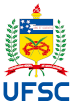</div>
    <div style="width: 100%; text-align: center;"><h1>Universidade Federal de Santa Catarina<br/>Centro Tecnológico<br/>Departamento de Informática e Estatística</h1></div>
    <div style="width:100px; text-align:center;">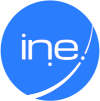</div>
</div>

<h3><strong>Disciplina:</strong> INE5664 - Aprendizado de Máquina<br/>
<strong>Turma:</strong> 07238<br/>
<strong>Curso:</strong> Sistemas de Informação<br/>
<strong>Professor:</strong> Eduardo Camilo Inacio<br/>
<strong>Alunos:</strong> Acaua Pitta, Isac Martins, Lucas Cunha</h3>

<h2>Processo de Classificação Binária com Rede Neural Personalizada

<h3>Introdução e Configuração do Ambiente</h3>

In [ ]:
### Instalação de Pacotes
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install matplotlib

### Configuração do Caminho
import sys
import os

sys.path.append(os.path.abspath('../src'))


### Importação de Bibliotecas
import numpy as np
import pandas as pd
from neural_network.neural import NeuralNetwork
from neural_network.layers.dense_layer import DenseLayer
from neural_network.layers.dropout_layer import DropoutLayer
from neural_network.optimizer import GradientDescent
from neural_network.losses import CrossEntropyLoss
from neural_network.utils import normalize_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import ( accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, mean_absolute_error,
    mean_squared_error, r2_score
)

: 

<h3>Leitura e Pré-processamento Inicial dos Dados</h3>

In [ ]:
### Leitura do Dataset
df = pd.read_csv('../data/binary/breast_cancer.csv')

### Remoção de colunas desnecessárias
df = df.drop('id', axis=1)
df = df.drop('Unnamed: 32', axis=1)

### Filtragem de Valores Válídos
valid_values = ['M', 'B']
df = df[df['diagnosis'].isin(valid_values)]

### Visualização Inicial dos Dados
df.head()


: 

In [ ]:
### Mapeia valores categóricos para numéricos (M -> 1, B -> 0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

### Separa os dados em recursos (X) e rótulos (y)
X = df.drop('diagnosis', axis=1).values
y = df['diagnosis'].values

### Exibe as primeiras 5 linhas do DataFrame para validação
df.head()


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
### Normaliza os dados de entrada para que todas as características estejam na mesma escala
X = normalize_data(X)

### Divide os dados em conjuntos de treinamento (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<h3>Configuração da Rede Neural e Inicialização do Modelo</h3>

In [ ]:
### Obtém o número de características do conjunto de treinamento
input_size = X_train.shape[1]

### Definição da arquitetura da rede neural
layers = [
    DenseLayer(input_size=input_size, output_size=16, activation='relu'),
    DropoutLayer(rate=0.2),  # Regularização para evitar overfitting
    DenseLayer(input_size=16, output_size=8, activation='relu'),
    DropoutLayer(rate=0.2),
    DenseLayer(input_size=8, output_size=4, activation='leaky_relu'),
    DenseLayer(input_size=4, output_size=1, activation='sigmoid') # Saída para classificação binária
]

### Definição da função de perda
loss = CrossEntropyLoss()

### Definição do otimizador
optimizer = GradientDescent(learning_rate=0.01)

### Inicialização do modelo de rede neural
model = NeuralNetwork(layers=layers, loss=loss, optimizer=optimizer)

<h3>Treinamento da Rede Neural</h3>

In [ ]:
### Definição do número de épocas para o treinamento
epochs = 800

### Loop principal do treinamento que itera pelo número de épocas
for epoch in range(epochs):
    ### Propagação direta: o modelo faz predições com base nos dados de treinamento
    y_pred = model.forward(X_train)
    
    ### Calcula a perda entre as predições do modelo e os rótulos reais
    loss_value = loss.calculate(y_train.reshape(-1, 1), y_pred)
    
    ### Propagação reversa: calcula os gradientes com base na função de perda
    model.backward(y_train.reshape(-1, 1), y_pred)
    
    ### Atualiza os pesos do modelo usando o otimizador (Gradient Descent)
    model.update()
    
    ### A cada 10 épocas, exibe métricas de desempenho no conjunto de treinamento
    if (epoch + 1) % 10 == 0:
        ### Converte as predições para classes binárias (1 ou 0) com base no limiar 0.5
        predictions = (y_pred > 0.5).astype(int)

        ### Calcula a acurácia das predições em relação aos rótulos reais
        acc = accuracy_score(y_train, predictions)

        ### Exibe o número da época, o valor da perda e a acurácia
        print(f'Epoch {epoch + 1}, Loss: {loss_value:.4f}, Accuracy: {acc:.4f}')


Epoch 10, Loss: 0.6792, Accuracy: 0.6198
Epoch 20, Loss: 0.6629, Accuracy: 0.6593
Epoch 30, Loss: 0.6488, Accuracy: 0.6945
Epoch 40, Loss: 0.6369, Accuracy: 0.7165
Epoch 50, Loss: 0.6269, Accuracy: 0.7385
Epoch 60, Loss: 0.6170, Accuracy: 0.7560
Epoch 70, Loss: 0.6071, Accuracy: 0.7648
Epoch 80, Loss: 0.5971, Accuracy: 0.7692
Epoch 90, Loss: 0.5872, Accuracy: 0.7846
Epoch 100, Loss: 0.5770, Accuracy: 0.7890
Epoch 110, Loss: 0.5664, Accuracy: 0.8000
Epoch 120, Loss: 0.5554, Accuracy: 0.8110
Epoch 130, Loss: 0.5442, Accuracy: 0.8154
Epoch 140, Loss: 0.5327, Accuracy: 0.8242
Epoch 150, Loss: 0.5208, Accuracy: 0.8330
Epoch 160, Loss: 0.5092, Accuracy: 0.8396
Epoch 170, Loss: 0.4974, Accuracy: 0.8396
Epoch 180, Loss: 0.4854, Accuracy: 0.8462
Epoch 190, Loss: 0.4735, Accuracy: 0.8484
Epoch 200, Loss: 0.4614, Accuracy: 0.8549
Epoch 210, Loss: 0.4493, Accuracy: 0.8571
Epoch 220, Loss: 0.4378, Accuracy: 0.8637
Epoch 230, Loss: 0.4266, Accuracy: 0.8659
Epoch 240, Loss: 0.4149, Accuracy: 0.8659
E

<h3>Avaliação do Modelo e Métricas de Desempenho</h3>

In [ ]:
### Faz a previsão do conjunto de teste
y_pred_test = model.forward(X_test)

### Converte as previsões para 0 ou 1, baseando-se no limiar de 0.5
predictions_test = (y_pred_test > 0.5).astype(int)

### Calcula a perda no conjunto de teste
test_loss = loss.calculate(y_test.reshape(-1, 1), y_pred_test)

### Calcula a acurácia do modelo no conjunto de teste
test_acc = accuracy_score(y_test, predictions_test)

### Calcula outras métricas de classificação
precision = precision_score(y_test, predictions_test)            # Precisão: porcentagem de positivos previstos corretamente
recall = recall_score(y_test, predictions_test)                  # Revocação: porcentagem de positivos reais identificados
f1 = f1_score(y_test, predictions_test)                          # F1 Score: média harmônica entre precisão e revocação
roc_auc = roc_auc_score(y_test, y_pred_test)                     # ROC-AUC: mede a capacidade de separação do modelo
conf_matrix = confusion_matrix(y_test, predictions_test)         # Matriz de confusão: tabela de verdade para previsões

### Relatório detalhado de métricas de classificação
classification_rep = classification_report(y_test, predictions_test)

### Calcula métricas de regressão (se aplicável)
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)


### Exibe as métricas calculadas
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

### Exibe as métricas de regressão, se aplicável
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Test Loss: 0.1930
Test Accuracy: 0.9035
Precision: 0.8810
Recall: 0.8605
F1 Score: 0.8706
ROC-AUC: 0.9781
Confusion Matrix:
[[66  5]
 [ 6 37]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92        71
           1       0.88      0.86      0.87        43

    accuracy                           0.90       114
   macro avg       0.90      0.90      0.90       114
weighted avg       0.90      0.90      0.90       114

Mean Absolute Error: 0.1336
Mean Squared Error: 0.0586
R² Score: 0.7507
